In [58]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from feature_engine.creation import CyclicalFeatures 
from utilsforecast.preprocessing import fill_gaps
from src.utils import ts_train_test_split
from src.plots import plot_time_series
from src.outliers import detect_outliers
from src.features import (
    add_calendar_features, 
    add_lagged_features, 
)

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [59]:
# leitura dos dados
df = pd.read_csv("data/data.csv", parse_dates=['ds'], sep=';')

In [60]:
# preenchendo os dados com os dias ausentes
df = fill_gaps(
    df=df,
    freq='D',
    start='global',
    end='per_serie'
).fillna(0)

## **Dados de Treino e Teste**
Para os experimentos, serão utilizados 80% de cada série para treinar os modelos, e o restante dos dados para avaliar suas performances.

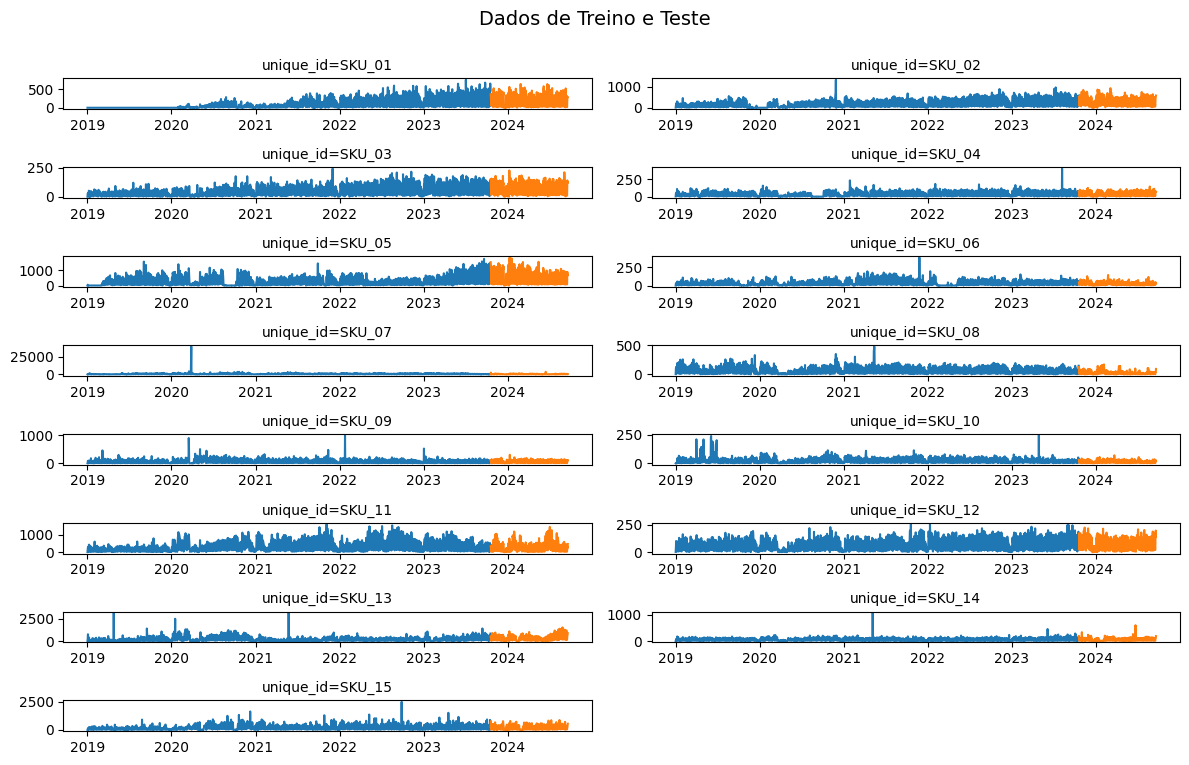

In [61]:
# dividindo dados em treino e teste
train_df, test_df = ts_train_test_split(df=df, test_size =336, id_col='unique_id')

# visualizando split
fig7 = plot_time_series(
    df=train_df.merge(test_df, how='outer', on=['unique_id', 'ds'], suffixes=['_train','_test']),
    data_cols=['y_train', 'y_test'],
    title='Dados de Treino e Teste',
    figsize=(12, 8)
)

In [62]:
# feature engineering
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

In [63]:

# outliers
features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

In [64]:
# inserindo os lags nos dados de treino e teste
kwargs = {
    'features' : ['feriado'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [65]:
features_train_df.max()

unique_id                     SKU_15
ds               2023-10-18 00:00:00
y                           40252.00
dia                               31
feriado                            1
dia_da_semana                      6
semana                            53
mes                               12
max_outliers                    1.00
min_outliers                    1.00
feriado_lag-3                   1.00
feriado_lag-2                   1.00
feriado_lag-1                   1.00
feriado_lag1                    1.00
feriado_lag2                    1.00
feriado_lag3                    1.00
dtype: object

In [66]:
features_train_df.dia_da_semana = features_train_df.dia_da_semana + 1
features_test_df.dia_da_semana = features_test_df.dia_da_semana + 1

features_to_encode = [
    "dia",
    "dia_da_semana",
    "semana",
    "mes",
]

max_values = {
    "dia": 31,
    "dia_da_semana" : 7,
    "semana": 53,
    "mes" : 12
}

cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)

In [67]:
# def _lag_y(df, test_size):
#     df['y_lag'] = df['y'].shift(test_size)
#     return df[test_size:-test_size], df[-test_size:]

# def lag_y(train_df, test_df, unique_id):
#     total_df = pd.concat(
#         [train_df, test_df], 
#         ignore_index=True
#     )
#     grouped_df = total_df.groupby(unique_id, group_keys=False)
#     train_df, test_df = zip(
#         *[_lag_y(group, 336) for _, group in grouped_df]
#     )
#     return pd.concat(train_df, ignore_index=True), pd.concat(test_df, ignore_index=True)

In [68]:
# features_train_df, features_test_df = lag_y(
#     train_df=features_train_df, 
#     test_df=features_test_df, 
#     unique_id='unique_id'
# )

In [69]:
# for i in range(1, 16):
#     _df = train_df
#     for x in pd.date_range(_df.ds.min() + pd.offsets.Day(336), _df.ds.max()):
#         sku = i
#         if i < 10:
#             sku = f'0{i}'
        
#         if x not in features_train_df.query(f"unique_id == 'SKU_{sku}'").ds.unique():
#             print(f'SKU+{sku} na base de treino não tem a data {x}')

# for i in range(1, 16):
#     _df = test_df
#     for x in pd.date_range(_df.ds.min(), _df.ds.max()):
#         sku = i
#         if i < 10:
#             sku = f'0{i}'
        
#         if x not in features_test_df.query(f"unique_id == 'SKU_{sku}'").ds.unique():
#             print(f'SKU+{sku} na base de teste não tem a data {x}')

In [70]:
# pandemia
import numpy as np
features_train_df['pandemia'] = np.where(
     (features_train_df['ds'] >= pd.to_datetime('2020-03-19')) & (features_train_df['ds'] <= pd.to_datetime('2020-05-03')),
     1, 0
)
features_test_df['pandemia'] = 0

In [71]:
features_train_df.to_csv('data/features_train_df.csv')
features_test_df.to_csv('data/features_test_df.csv')

## **RFECV**

In [72]:
selected_features = {}
# skus = ['SKU_03', 'SKU_04', 'SKU_06','SKU_12']
# features_train_df = features_train_df.query('unique_id in @skus')

In [73]:
def feature_selection(df : pd.DataFrame) -> pd.DataFrame:

    train = df.copy().reset_index(drop=True)
    train['trend'] = train.index
    
    # etapa de seleção de features
    model = RandomForestRegressor(
        n_estimators=100, 
        random_state=1001
    )
    selection = RFECV(model, cv=4, n_jobs=-1, min_features_to_select=5)
    selection.fit(X=train.iloc[:,3:], y=train.y)
    
    selected_features[train.unique_id[0]] = train.columns[3:][selection.support_]

In [74]:
# aplicando modelo para cada série
rf_fcst = features_train_df.groupby("unique_id") \
        .progress_apply(feature_selection) \
        .reset_index(drop=True)

100%|██████████| 15/15 [09:26<00:00, 37.77s/it]


In [75]:
selected_features

{'SKU_01': Index(['feriado', 'dia_da_semana', 'semana', 'dia_cos', 'trend'], dtype='object'),
 'SKU_02': Index(['dia', 'feriado', 'dia_da_semana', 'semana', 'max_outliers',
        'min_outliers', 'dia_sin', 'semana_sin', 'mes_sin', 'mes_cos', 'trend'],
       dtype='object'),
 'SKU_03': Index(['dia', 'feriado', 'dia_da_semana', 'semana', 'max_outliers', 'dia_sin',
        'dia_cos', 'dia_da_semana_sin', 'dia_da_semana_cos', 'semana_sin',
        'semana_cos', 'mes_sin', 'pandemia', 'trend'],
       dtype='object'),
 'SKU_04': Index(['dia', 'feriado', 'dia_da_semana', 'semana', 'mes', 'max_outliers',
        'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
        'feriado_lag2', 'feriado_lag3', 'dia_sin', 'dia_cos',
        'dia_da_semana_sin', 'dia_da_semana_cos', 'semana_sin', 'semana_cos',
        'mes_sin', 'mes_cos', 'pandemia', 'trend'],
       dtype='object'),
 'SKU_05': Index(['dia', 'feriado', 'dia_da_semana', 'semana', 'mes', 'max_outliers',
        'min_ou

In [76]:
import json

for i, x in zip(selected_features.keys(),selected_features.values()):
    selected_features[i] = x.tolist()
    
with open("data/features.json", "w", encoding="utf-8") as arquivo:
    json.dump(selected_features, arquivo, ensure_ascii=False, indent=4)